In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from itertools import product

In [2]:
# Read the data
df = pd.read_csv('train.csv')
df['date_time'] = pd.to_datetime(df['date_time'])
df.set_index('date_time', inplace=True)

In [3]:
df.head()

,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume
date_time,,,,,,,,,,,,,,
2012-10-02 09:00:00,None,121,89,2,329,1,1,288.28,0.0,0.0,40,Clouds,scattered clouds,5545
2012-10-02 10:00:00,None,178,67,3,330,1,1,289.36,0.0,0.0,75,Clouds,broken clouds,4516
2012-10-02 11:00:00,None,113,66,3,329,2,2,289.58,0.0,0.0,90,Clouds,overcast clouds,4767
2012-10-02 12:00:00,None,20,66,3,329,5,5,290.13,0.0,0.0,90,Clouds,overcast clouds,5026
2012-10-02 13:00:00,None,281,65,3,329,7,7,291.14,0.0,0.0,75,Clouds,broken clouds,4918


In [4]:
# Resample data to daily frequency
df_daily = df.resample('D').sum()

# Split data into train and test
train_size = int(len(df_daily) * 0.8)
train, test = df_daily.iloc[:train_size], df_daily.iloc[train_size:]

C:\Users\Nadim Pramono\AppData\Local\Temp\ipykernel_20128\1105851995.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_daily = df.resample('D').sum()


In [5]:
# Grid search for SARIMAX parameters
p = d = q = range(0, 3)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

In [6]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = SARIMAX(train['traffic_volume'],
                                 order = param,
                                 seasonal_order = param_seasonal,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
            results = temp_model.fit()
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

print(f"Best SARIMAX{best_pdq}x{best_seasonal_pdq} model - AIC:{best_aic}")

C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

Best SARIMAX(2, 1, 2)x(2, 0, 2, 12) model - AIC:30655.992052131973


In [7]:
# Fitting the model with best parameters
model = SARIMAX(train['traffic_volume'],
                order=best_pdq,
                seasonal_order=best_seasonal_pdq,
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Predictions
preds = results.get_prediction(start=pd.to_datetime(test.index[0]), 
                               end=pd.to_datetime(test.index[-1]), 
                               dynamic=False)
pred_conf = preds.conf_int()

C:\Users\Nadim Pramono\PycharmProjects\pythonProject1\v392\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


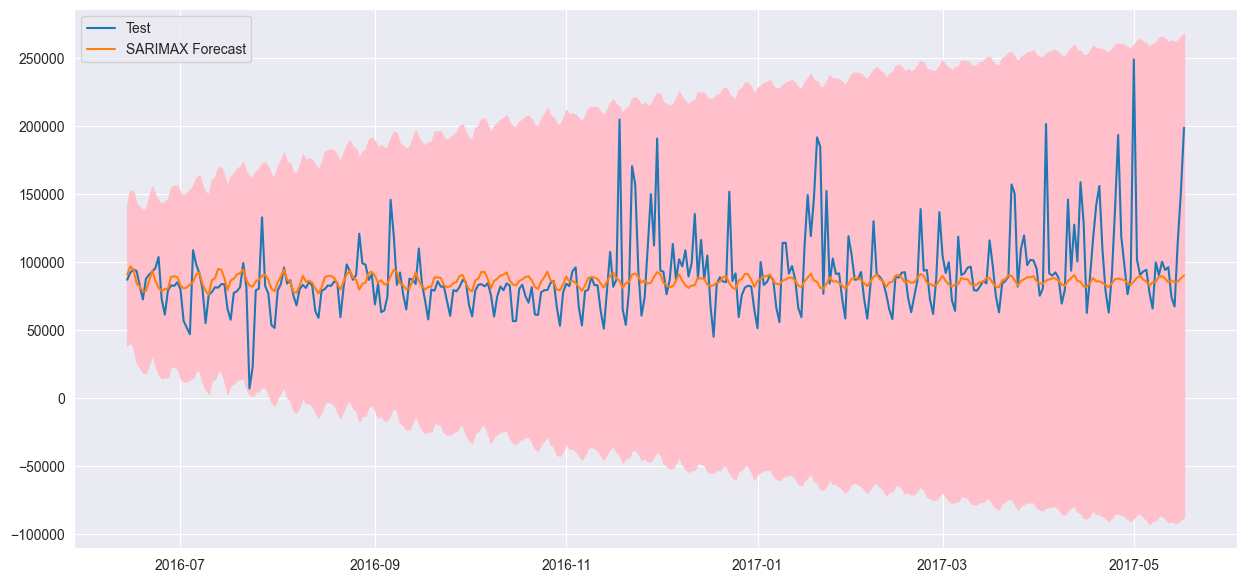

In [11]:
# Plotting the results
plt.figure(figsize=(15, 7))
#plt.plot(train.index, train['traffic_volume'], label='Train')
plt.plot(test.index, test['traffic_volume'], label='Test')
plt.plot(preds.predicted_mean.index, preds.predicted_mean, label='SARIMAX Forecast')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink')
plt.legend()
plt.show()

is_holiday             0
air_pollution_index    0
humidity               0
wind_speed             0
wind_direction         0
visibility_in_miles    0
dew_point              0
temperature            0
rain_p_h               0
snow_p_h               0
clouds_all             0
weather_type           0
weather_description    0
traffic_volume         0
dtype: int64